# 06-Lab-03-10-2025


## Classification: KNN, Naive Bayes, Decision Tree, Random Forest


### DataSet Used :- Cars Dataset


#### Setup Section


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from itertools import cycle

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc
)

# Inline plots and style
%matplotlib inline
sns.set_theme(style="whitegrid", font_scale=1.05)
randomState = 42


#### Usage Of CSV Dataset


In [2]:
dataPath = 'DataSet/cars.csv'
targetCol = 'Drivetrain'  # change to 'Emission_Norm' if preferred

dataFrame = pd.read_csv(dataPath)
print('Dataset shape:', dataFrame.shape)
display(dataFrame.head())
print('\nColumns:', list(dataFrame.columns))
if targetCol in dataFrame.columns:
    print('\nTarget distribution:')
    print(dataFrame[targetCol].value_counts())
else:
    print(f"Target column '{targetCol}' not found. Consider setting targetCol='Emission_Norm'.")


Dataset shape: (1276, 140)


,Make,Model,Variant,Ex-Showroom_Price,Displacement,Cylinders,Valves_Per_Cylinder,Drivetrain,Cylinder_Configuration,Emission_Norm,...,Leather_Wrapped_Steering,Automatic_Headlamps,Engine_Type,ASR_/_Traction_Control,Cruise_Control,USB_Ports,Heads-Up_Display,Welcome_Lights,Battery,Electric_Range
0,Tata,Nano Genx,Xt,"Rs. 2,92,667",624 cc,2.0,2.0,RWD (Rear Wheel Drive),In-line,BS IV,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Tata,Nano Genx,Xe,"Rs. 2,36,447",624 cc,2.0,2.0,RWD (Rear Wheel Drive),In-line,BS IV,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Tata,Nano Genx,Emax Xm,"Rs. 2,96,661",624 cc,2.0,2.0,RWD (Rear Wheel Drive),In-line,BS IV,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Tata,Nano Genx,Xta,"Rs. 3,34,768",624 cc,2.0,2.0,RWD (Rear Wheel Drive),In-line,BS IV,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Tata,Nano Genx,Xm,"Rs. 2,72,223",624 cc,2.0,2.0,RWD (Rear Wheel Drive),In-line,BS IV,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Columns: ['Make', 'Model', 'Variant', 'Ex-Showroom_Price', 'Displacement', 'Cylinders', 'Valves_Per_Cylinder', 'Drivetrain', 'Cylinder_Configuration', 'Emission_Norm', 'Engine_Location', 'Fuel_System', 'Fuel_Tank_Capacity', 'Fuel_Type', 'Height', 'Length', 'Width', 'Body_Type', 'Doors', 'City_Mileage', 'Highway_Mileage', 'ARAI_Certified_Mileage', 'ARAI_Certified_Mileage_for_CNG', 'Kerb_Weight', 'Gears', 'Ground_Clearance', 'Front_Brakes', 'Rear_Brakes', 'Front_Suspension', 'Rear_Suspension', 'Front_Track', 'Rear_Track', 'Front_Tyre_&_Rim', 'Rear_Tyre_&_Rim', 'Power_Steering', 'Power_Windows', 'Power_Seats', 'Keyless_Entry', 'Power', 'Torque', 'Odometer', 'Speedometer', 'Tachometer', 'Tripmeter', 'Seating_Capacity', 'Seats_Material', 'Type', 'Wheelbase', 'Wheels_Size', 'Start_/_Stop_Button', '12v_Power_Outlet', 'Audiosystem', 'Aux-in_Compatibility', 'Average_Fuel_Consumption', 'Basic_Warranty', 'Bluetooth', 'Boot-lid_Opener', 'Boot_Space', 'CD_/_MP3_/_DVD_Player', 'Central_Locking', 'C

#### Clean numeric fields


In [3]:
# Create cleaned numeric columns when present (idempotent)
if 'Ex-Showroom_Price' in dataFrame.columns and 'Ex-Showroom_Price_Cleaned' not in dataFrame.columns:
    dataFrame['Ex-Showroom_Price_Cleaned'] = (
        dataFrame['Ex-Showroom_Price']
          .astype(str)
          .str.replace(r'[^0-9]', '', regex=True)
          .replace('', np.nan)
          .astype(float)
    )
if 'Displacement' in dataFrame.columns and 'Displacement_Cleaned' not in dataFrame.columns:
    dataFrame['Displacement_Cleaned'] = (
        dataFrame['Displacement']
          .astype(str)
          .str.replace(' cc', '', regex=False)
          .replace('', np.nan)
          .astype(float)
    )

for colName in ['Cylinders','Valves_Per_Cylinder','Doors','Seating_Capacity','Number_of_Airbags','USB_Ports','Displacement_Cleaned','Ex-Showroom_Price_Cleaned']:
    if colName in dataFrame.columns:
        print(colName, 'unique:', dataFrame[colName].nunique())


Cylinders unique: 9
Valves_Per_Cylinder unique: 8
Doors unique: 4
Seating_Capacity unique: 8
Number_of_Airbags unique: 11
USB_Ports unique: 3
Displacement_Cleaned unique: 129
Ex-Showroom_Price_Cleaned unique: 1179


#### Feature selection


In [4]:
candidateFeatures = [
    'Cylinders','Valves_Per_Cylinder','Doors','Seating_Capacity',
    'Number_of_Airbags','USB_Ports','Displacement_Cleaned','Ex-Showroom_Price_Cleaned'
]
features = [f for f in candidateFeatures if f in dataFrame.columns]
print('Selected features:', features)


Selected features: ['Cylinders', 'Valves_Per_Cylinder', 'Doors', 'Seating_Capacity', 'Number_of_Airbags', 'USB_Ports', 'Displacement_Cleaned', 'Ex-Showroom_Price_Cleaned']


#### Prepare data & encode target


In [5]:
if targetCol not in dataFrame.columns:
    raise ValueError(f"Target column '{targetCol}' not found — set targetCol to a valid column.")

subsetFrame = dataFrame[features + [targetCol]].copy()
print('Before dropna:', subsetFrame.shape)
subsetFrame = subsetFrame.dropna().reset_index(drop=True)
print('After dropna:', subsetFrame.shape)

X = subsetFrame[features].astype(float)
labelEncoder = LabelEncoder()
y = labelEncoder.fit_transform(subsetFrame[targetCol])
classMapping = dict(enumerate(labelEncoder.classes_))
print('Class mapping:', classMapping)


Before dropna: (1276, 9)
After dropna: (29, 9)
Class mapping: {0: 'AWD (All Wheel Drive)', 1: 'FWD (Front Wheel Drive)', 2: 'RWD (Rear Wheel Drive)'}


#### Train/test split


In [6]:
XTrain, XTest, yTrain, yTest = train_test_split(
    X, y, test_size=0.25, random_state=randomState, stratify=y
)
print('Train/Test sizes:', XTrain.shape, XTest.shape)


Train/Test sizes: (21, 8) (8, 8)


#### Scaling


In [7]:
scaler = StandardScaler()
XTrainScaled = scaler.fit_transform(XTrain)
XTestScaled = scaler.transform(XTest)


#### Define models & param grids


In [8]:
models = {
    'KNN': KNeighborsClassifier(),
    'NaiveBayes': GaussianNB(),
    'DecisionTree': DecisionTreeClassifier(random_state=randomState),
    'RandomForest': RandomForestClassifier(random_state=randomState)
}

paramGrids = {
    'KNN': {'n_neighbors': [3,5,7,9], 'weights':['uniform','distance'], 'p':[1,2]},
    'NaiveBayes': {},
    'DecisionTree': {'max_depth':[3,5,8,12], 'criterion':['gini','entropy']},
    'RandomForest': {'n_estimators':[50,100], 'max_depth':[4,6,10]}
}


#### GridSearchCV training (CV=4)


In [9]:
bestEstimators = {}
for name, model in models.items():
    print(f"\nTraining {name} ...")
    grid = GridSearchCV(model, paramGrids[name], cv=4, scoring='accuracy', n_jobs=-1, verbose=0)
    grid.fit(XTrainScaled, yTrain)
    bestEstimators[name] = grid.best_estimator_
    print(f"{name} best params: {grid.best_params_} | CV best score: {grid.best_score_:.4f}")



Training KNN ...
KNN best params: {'n_neighbors': 3, 'p': 2, 'weights': 'distance'} | CV best score: 0.7750

Training NaiveBayes ...
NaiveBayes best params: {} | CV best score: 0.7250

Training DecisionTree ...
DecisionTree best params: {'criterion': 'gini', 'max_depth': 3} | CV best score: 0.8083

Training RandomForest ...
RandomForest best params: {'max_depth': 4, 'n_estimators': 50} | CV best score: 0.7250


#### Test set evaluation



=== KNN ===
                         precision    recall  f1-score   support

  AWD (All Wheel Drive)       1.00      1.00      1.00         2
FWD (Front Wheel Drive)       1.00      1.00      1.00         5
 RWD (Rear Wheel Drive)       1.00      1.00      1.00         1

               accuracy                           1.00         8
              macro avg       1.00      1.00      1.00         8
           weighted avg       1.00      1.00      1.00         8



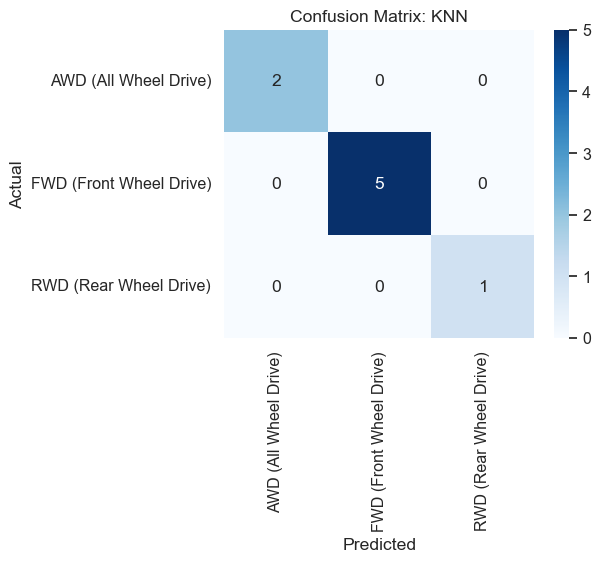


=== NaiveBayes ===
                         precision    recall  f1-score   support

  AWD (All Wheel Drive)       1.00      0.50      0.67         2
FWD (Front Wheel Drive)       0.83      1.00      0.91         5
 RWD (Rear Wheel Drive)       1.00      1.00      1.00         1

               accuracy                           0.88         8
              macro avg       0.94      0.83      0.86         8
           weighted avg       0.90      0.88      0.86         8



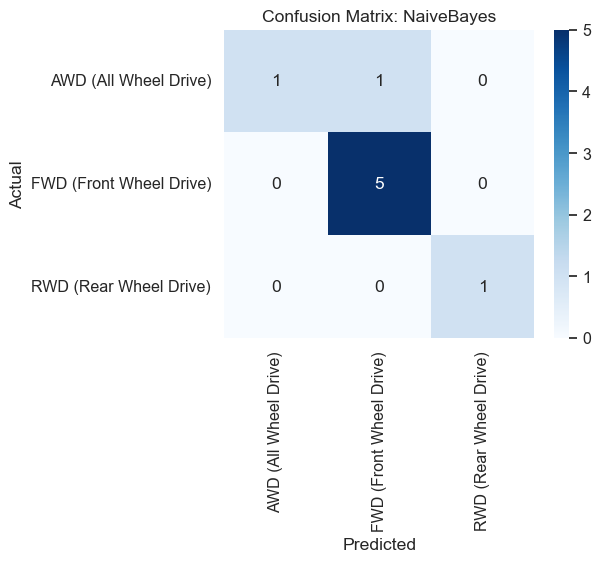


=== DecisionTree ===
                         precision    recall  f1-score   support

  AWD (All Wheel Drive)       1.00      0.50      0.67         2
FWD (Front Wheel Drive)       1.00      1.00      1.00         5
 RWD (Rear Wheel Drive)       0.50      1.00      0.67         1

               accuracy                           0.88         8
              macro avg       0.83      0.83      0.78         8
           weighted avg       0.94      0.88      0.88         8



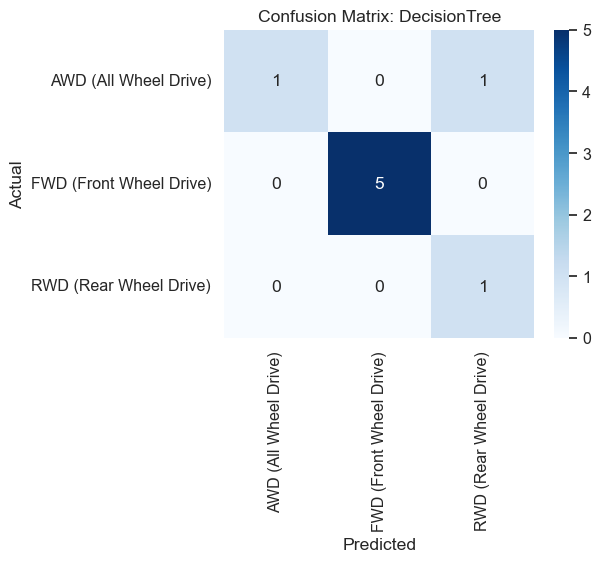


=== RandomForest ===
                         precision    recall  f1-score   support

  AWD (All Wheel Drive)       1.00      1.00      1.00         2
FWD (Front Wheel Drive)       1.00      1.00      1.00         5
 RWD (Rear Wheel Drive)       1.00      1.00      1.00         1

               accuracy                           1.00         8
              macro avg       1.00      1.00      1.00         8
           weighted avg       1.00      1.00      1.00         8



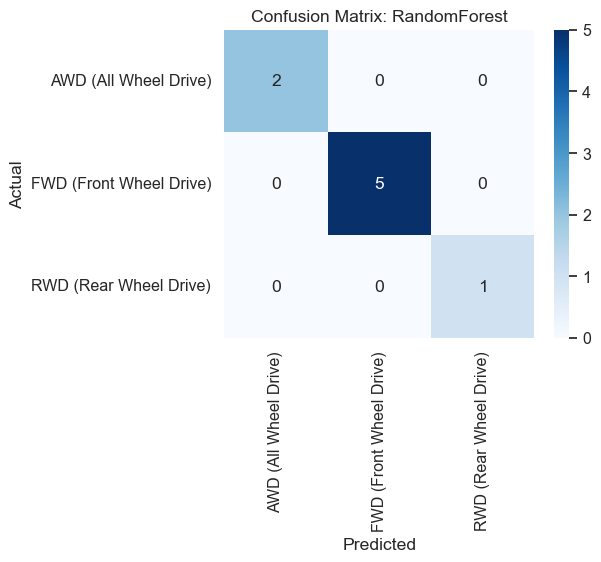

,Accuracy,Precision_macro,Recall_macro,F1_macro
Model,,,,
KNN,1.000,1.000000,1.000000,1.000000
NaiveBayes,0.875,0.944444,0.833333,0.858586
DecisionTree,0.875,0.833333,0.833333,0.777778
RandomForest,1.000,1.000000,1.000000,1.000000


In [10]:
resultsList = []
for name, est in bestEstimators.items():
    yPred = est.predict(XTestScaled)
    acc = accuracy_score(yTest, yPred)
    prec = precision_score(yTest, yPred, average='macro', zero_division=0)
    rec = recall_score(yTest, yPred, average='macro', zero_division=0)
    f1 = f1_score(yTest, yPred, average='macro', zero_division=0)
    resultsList.append({'Model': name, 'Accuracy': acc, 'Precision_macro': prec, 'Recall_macro': rec, 'F1_macro': f1})

    print(f"\n=== {name} ===")
    print(classification_report(yTest, yPred, target_names=labelEncoder.classes_, zero_division=0))
    cm = confusion_matrix(yTest, yPred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=labelEncoder.classes_, yticklabels=labelEncoder.classes_, cmap='Blues')
    plt.title(f'Confusion Matrix: {name}')
    plt.xlabel('Predicted'); plt.ylabel('Actual')
    plt.show()

resultsFrame = pd.DataFrame(resultsList).set_index('Model')
display(resultsFrame)


#### ROC curves (micro & macro, OvR)


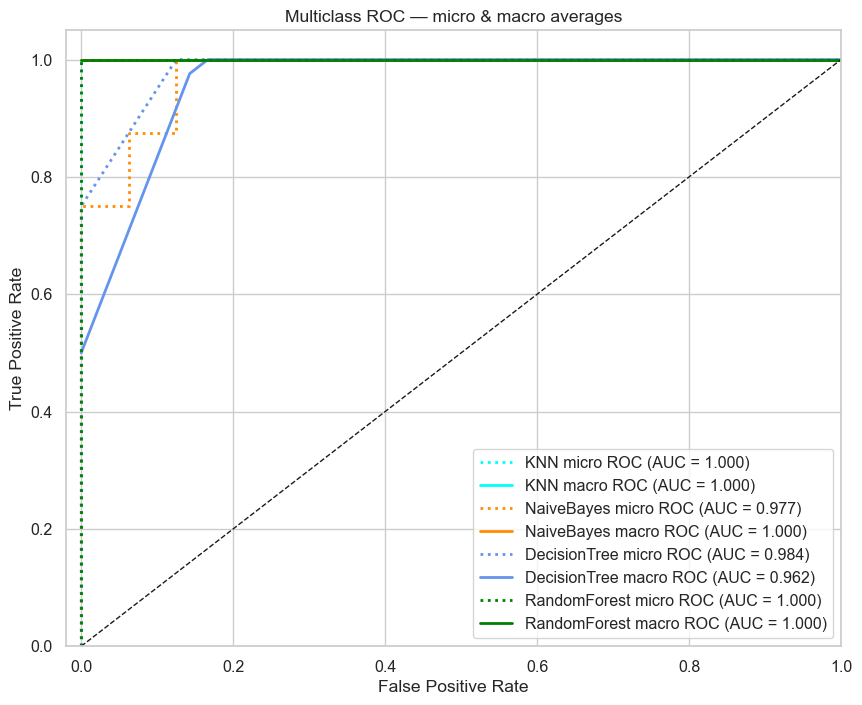

In [11]:
nClasses = len(labelEncoder.classes_)
yTestBin = label_binarize(yTest, classes=np.arange(nClasses))

plt.figure(figsize=(10,8))
colorCycle = cycle(['aqua','darkorange','cornflowerblue','green','red','purple','brown'])
for (name, est), color in zip(bestEstimators.items(), colorCycle):
    if hasattr(est, 'predict_proba'):
        yScore = est.predict_proba(XTestScaled)
    elif hasattr(est, 'decision_function'):
        yScore = est.decision_function(XTestScaled)
    else:
        print(f'Skipping ROC for {name}: no probability or decision scores.')
        continue

    fpr = {}; tpr = {}; rocAuc = {}
    for i in range(nClasses):
        fpr[i], tpr[i], _ = roc_curve(yTestBin[:, i], yScore[:, i])
        rocAuc[i] = auc(fpr[i], tpr[i])

    fpr['micro'], tpr['micro'], _ = roc_curve(yTestBin.ravel(), yScore.ravel())
    rocAuc['micro'] = auc(fpr['micro'], tpr['micro'])

    allFpr = np.unique(np.concatenate([fpr[i] for i in range(nClasses)]))
    meanTpr = np.zeros_like(allFpr)
    for i in range(nClasses):
        meanTpr += np.interp(allFpr, fpr[i], tpr[i])
    meanTpr /= nClasses
    fpr['macro'] = allFpr
    tpr['macro'] = meanTpr
    rocAuc['macro'] = auc(fpr['macro'], tpr['macro'])

    plt.plot(fpr['micro'], tpr['micro'], label=f"{name} micro ROC (AUC = {rocAuc['micro']:.3f})", color=color, linestyle=':', linewidth=2)
    plt.plot(fpr['macro'], tpr['macro'], label=f"{name} macro ROC (AUC = {rocAuc['macro']:.3f})", color=color, linewidth=2)

plt.plot([0,1],[0,1],'k--',lw=1)
plt.xlim([-0.02,1.0]); plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC — micro & macro averages')
plt.legend(loc='lower right')
plt.show()


#### Comparison chart


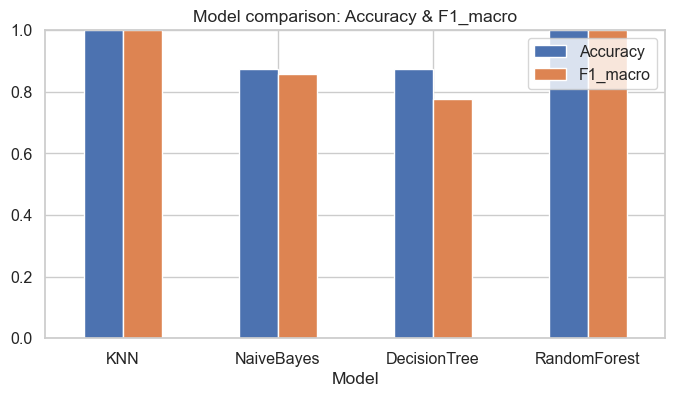

In [12]:
resultsFrame[['Accuracy','F1_macro']].plot(kind='bar', rot=0, figsize=(8,4), title='Model comparison: Accuracy & F1_macro')
plt.ylim(0,1)
plt.show()


#### Save best models


In [13]:
for name, est in bestEstimators.items():
    joblib.dump({'model': est, 'scaler': scaler, 'label_encoder': labelEncoder, 'features': features}, f'{name}_cars_model.joblib')
print('Saved model files for each classifier (model + scaler + label encoder).')


Saved model files for each classifier (model + scaler + label encoder).
